<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1aS4vX-ucDKBmZmZMrBwgjl_DvLAadX2C" width=900/></p>


<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. RAG.

В этом домашнем задании вам предстоит создать туристический RAG, провести EDA и проявить креатив! :)

Вам дан набор данных, содержащий информацию о памятниках, архитектуре и других значимых местах. В данных есть:
* название достопримечательности;
* идентификатор на WikiData;
* город расположения;
* координаты долготы и широты;
* описание (извлеченное из WikiData);
* изображение в формате base64;
* сгенерированное описание изображения (генерация с помощью модели BLIP).

Некоторые из памятников могут встречаться несколько раз, но с различными изображениями, из которых не все могут быть качественными. Для компенсации этого даны текстовые описания.

Часть данных взята с Национальной технологической олимпиады студентов по CV. Базовое решение предполагает использование мультимодального ru-CLIP. Но в данном домашнем задании предлагается решить эту задачу творчески, используя NLP подход.

## Установка и импорт библиотек

In [ ]:
# !pip install -q gdown torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl datasets langchain-community ragatouille umap-learn

In [ ]:
import gdown
import pandas as pd
from tqdm.notebook import tqdm
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
from langchain.docstore.document import Document as LangchainDocument
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import numpy as np
import plotly.express as px
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from ragatouille import RAGPretrainedModel

#------------------------------------------------------------------------------------
# from langchain.text_splitter import ... # выберите другую стратегию разбивки на чанки

# pd.set_option("display.max_colwidth", None)

## Загрузка данных (4 балла)

In [2]:
url = 'https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk'
output = 'file.csv'

# gdown.download(url, output, quiet=False)

data = pd.read_csv('file.csv')
data.rename(columns={ data.columns[0]: "Id" }, inplace = True)
data.head()

,Id,Name,WikiData,City,Lon,Lat,description,image,en_txt
0,0,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
1,1,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white exterior...
2,2,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
3,3,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
4,4,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a boat that is in the water near a bu...


Для декодирования изображений, закодированных в формате base64, можно использовать следующий код:

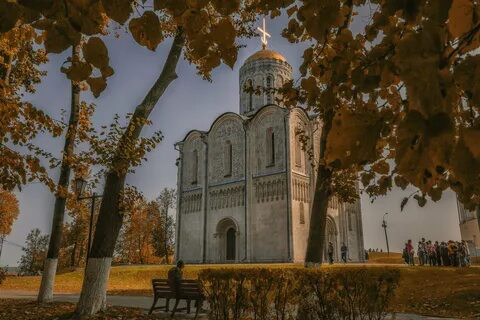

In [3]:
import base64
import requests
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
import io
from io import BytesIO

def get_image(data):
  image = Image.open(BytesIO(base64.b64decode(data))).convert('RGB')
  return image

get_image(data.sample(1)['image'].tolist()[0])

## I. Очистка данных 

В данных есть выбросы — записи, не относящихся к туристическим или историческим объектам. Для очистки данных можно, например, использовать алгоритм TF-IDF: создаем корпус текстов из описаний, применяем TF-IDF, извлекаем наиболее редко или часто встречающиеся слова. Они могут указывать на мусорные данные, такие как мемы, баннеры или личные фото людей. После выделения подозрительных паттернов, можно провести ручную проверку и фильтрацию данных.

Для дальнейшего тестирования и получения чистых сэмплов, рекомендуется взять не менее 100 чистых образцов со стратификацией по городу и названию места. Это можно сделать, выбрав случайным образом несколько образцов из каждой категории (город + название места), чтобы обеспечить равномерное представительство и разнообразие данных.

**!! Важно:** Помните, что чистые сэмплы одного и того же места выдадут примерно одинаковое описание. Есть несколько стратегий, как повысить разнообразие ответов:

- выбор одного самого лучшего:
  - самое длинное описание
  - смое подходящие по мнению LLM
- конкатенация описаний (но важно не сконкатенировать слишком много)

Изображения можно отдать в мета-данные.

In [4]:
# I. Очистка данных 

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

# Получаем стоп-слова
# russian_stop_words = stopwords.words('russian')
english_stop_words = stopwords.words('english')


# Удаление пропущенных значений в колонке description
data = data.dropna(subset=['en_txt'])

# Создание корпуса текстов
corpus = data['en_txt'].tolist()

# Применение TF-IDF
vectorizer = TfidfVectorizer(stop_words=english_stop_words, max_features=1000) # stop_words='english'
X = vectorizer.fit_transform(corpus)

# Извлечение слов с максимальными и минимальными TF-IDF весами
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = np.asarray(X.mean(axis=0)).flatten()


# Пороговые значения для определения выбросов
low_threshold = np.percentile(tfidf_scores, 5)  # Нижние 5%
high_threshold = np.percentile(tfidf_scores, 97)  # Верхние 5%

# Определение нерелевантных слов
low_tfidf_words = set(feature_names[tfidf_scores <= low_threshold])
high_tfidf_words = set(feature_names[tfidf_scores >= high_threshold])

# Вывод нерелевантных слов (для анализа)
print("Слова с низкими TF-IDF весами:", low_tfidf_words)
print("Слова с высокими TF-IDF весами:", high_tfidf_words)

# Фильтрация данных
filtered_data = data[~data['en_txt'].str.contains('|'.join(low_tfidf_words | high_tfidf_words), case=False)]

# Сохранение очищенных данных
# filtered_data.to_csv('cleaned_file.csv', index=False)
# print("Данные успешно очищены и сохранены в cleaned_file.csv")

# Стратификация - 5 самых длинных описаний
sampled_data = (
    filtered_data.groupby(['City', 'Name'], group_keys=False)
    # .apply(lambda x: x.sort_values(by='description', key=lambda s: s.str.len(), ascending=False).head(5)) # Берем 5 самых длинных описаний
    .apply(lambda x: x.sort_values(by='en_txt', key=lambda s: s.str.len(), ascending=False).head(10)) # Берем 5 самых длинных описаний
    .drop_duplicates(subset='en_txt', keep='first')
    .reset_index(drop=True)
    .dropna()
)

print(len(sampled_data))
sampled_data.head(3)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ritz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Слова с низкими TF-IDF весами: {'native', 'sticks', 'sticking', 'trunk', 'sound', 'skeletons', 'speech', 'parts', 'pinning', 'theme', 'nurses', 'wallpaper', 'states', 'swans', 'tin', 'pieces', 'worked', 'mushrooms', 'party', 'sizes', 'shining', 'shirts', 'page', 'united', 'performers', 'popcorn', 'mound', 'thomas', 'shark', 'ha', 'panels', 'routine', 'teacher', 'petersburg', 'peacock', 'york', 'weapons', 'technology', 'placing', 'putting', 'work', 'tongue', 'program', 'soda', 'skirt', 'public', 'shaped', 'sheet', 'saluting', 'ship'}
Слова с высокими TF-IDF весами: {'standing', 'statue', 'tower', 'front', 'green', 'golden', 'building', 'cars', 'sign', 'steeple', 'city', 'arafed', 'brick', 'roof', 'domes', 'man', 'large', 'clock', 'parked', 'church', 'top', 'lot', 'dome', 'blue', 'white', 'street', 'red', 'view', 'people', 'park'}
273


C:\Users\Ritz\AppData\Local\Temp\ipykernel_22348\1361414523.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sort_values(by='en_txt', key=lambda s: s.str.len(), ascending=False).head(10)) # Берем 5 самых длинных описаний


,Id,Name,WikiData,City,Lon,Lat,description,image,en_txt
11,991,église arménienne de Vladimir,Q18331756,Владимир,40.456497,56.154667,Армянская церковь в г. Владимир России,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,a computer generated image of a rocky landscap...
12,984,église arménienne de Vladimir,Q18331756,Владимир,40.456497,56.154667,Армянская церковь в г. Владимир России,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,a map of the sky with a line of stars and a li...
13,988,église arménienne de Vladimir,Q18331756,Владимир,40.456497,56.154667,Армянская церковь в г. Владимир России,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,a close up of two planets with the same size a...


  0%|          | 0/14634 [00:00<?, ?it/s]

  0%|          | 0/14634 [00:00<?, ?it/s]

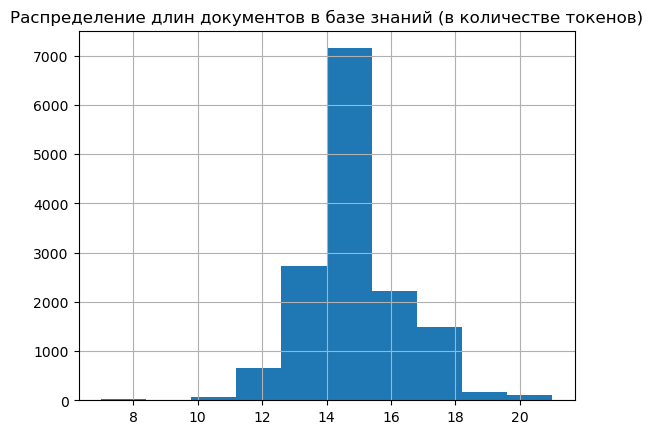

In [5]:
from langchain.docstore.document import Document as LangchainDocument
from transformers import AutoTokenizer

# Преобразуем DataFrame в список LangchainDocument
RAW_KNOWLEDGE_BASE_test = [
    LangchainDocument(
        page_content=row['en_txt'],
        metadata={
            "name": row['Name'],
            "city": row['City'],
            "lon": row['Lon'],
            "lat": row['Lat'],
            "wikidata": row['WikiData']
        }
    )
    for _, row in tqdm(data.iterrows(), total=data.shape[0])
]

tokenizer = AutoTokenizer.from_pretrained("thenlper/gte-small")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(RAW_KNOWLEDGE_BASE_test)]

# Построим график распределения длин документов, подсчитываемых как количество токенов
fig = pd.Series(lengths).hist()
plt.title("Распределение длин документов в базе знаний (в количестве токенов)")
plt.show()

## II. Построить RAG

Здесь предлагаем вам построить RAG с использованием моделей, которые не были представлены на семинаре (включая другие векторные базы данных). Можно воспользоваться материалами по этой ссылке: [data_connection/vectorstores](https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/).

!Важно, не забудьте отранжировать чанки текстов с помощью `ragatouille`. На практике порядок текстов в промпте влияет на точность ответа.

In [12]:
## II.1 Построить RAG - Qdrant vector Database / Fastembed

from qdrant_client import QdrantClient, models
from qdrant_client.models import Distance, VectorParams
from tqdm import tqdm
import pandas as pd
from fastembed import TextEmbedding


# Initialize Qdrant client - vector database in RAM
client = QdrantClient(":memory:")


# Prepare documents, metadata, and IDs
docs = sampled_data['en_txt'].tolist()  # Extract the 'en_txt' column as documents
metadata = [
    {
        "name": name,
        "city": city,
        "lon": lon,
        "lat": lat,
        "wikidata": wikidata,
        "en_txt": en_txt
    }  # , "image": image
    for name, city, lon, lat, wikidata, en_txt in zip(   # , image
        sampled_data['Name'],
        sampled_data['City'],
        sampled_data['Lon'],
        sampled_data['Lat'],
        sampled_data['WikiData'],
        sampled_data['en_txt']
        # sampled_data['image']
    )
]
ids = sampled_data['Id'].tolist()  # Use the 'Id' column as IDs


# Initialize embedding model with GPU
embedding_model = TextEmbedding(model_name="BAAI/bge-small-en-v1.5", providers=["CUDAExecutionProvider"])
print("The model BAAI/bge-small-en-v1.5 is ready to use on GPU.")

# Generate embeddings
embeddings_generator = embedding_model.embed(docs)
embeddings_list = list(embeddings_generator)
print(f"Embedding dimensions: {len(embeddings_list[0])}")  # Confirm vector size


# Define collection parameters
vector_size = len(embeddings_list[0])  # Example: 384 dimensions
collection_name = "my_collection"
client.recreate_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=vector_size, distance=Distance.COSINE)
)

# Upsert points into the collection
points = [
    models.PointStruct(id=id, vector=vector, payload=meta)
    for id, vector, meta in zip(ids, embeddings_list, metadata)
]


# KNOWLEDGE_VECTOR_DATABASE
client.upsert(
    collection_name=collection_name,
    points=points
)


# Query the collection
query_text = "Find city where is a table with a computer and a book on it ?"

# Generate embedding for the query
query_embedding_generator = embedding_model.embed([query_text])  # This returns a generator
query_embedding = list(query_embedding_generator)[0]  # Convert to list and take the first element

# Perform search
search_result = client.search(
    collection_name=collection_name,
    query_vector=query_embedding,
    limit=5  # Return top 5 results
)

# Display results
for result in search_result:
    print(f"ID: {result.id}, Score: {result.score}, Metadata: {result.payload}")

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

The model BAAI/bge-small-en-v1.5 is ready to use on GPU.
Embedding dimensions: 384
ID: 3399, Score: 0.8011623620986938, Metadata: {'name': 'Центральная городская библиотека им. А. И. Герцена', 'city': 'Екатеринбург', 'lon': 60.612167, 'lat': 56.821865, 'wikidata': 'Q4504106', 'en_txt': 'there is a table with a computer and a book on it'}
ID: 193, Score: 0.7132244110107422, Metadata: {'name': 'Дом-музей Бажова', 'city': 'Екатеринбург', 'lon': 60.613415, 'lat': 56.818394, 'wikidata': 'Q4290214', 'en_txt': 'there is a table with a book on it in a room'}
ID: 2704, Score: 0.702008068561554, Metadata: {'name': 'Музей науки «Нижегородская радиолаборатория»', 'city': 'Нижний Новгород', 'lon': 44.013882, 'lat': 56.329411, 'wikidata': 'Q1994279', 'en_txt': 'a close up of a table with a bunch of old electronic equipment'}
ID: 147, Score: 0.6881264448165894, Metadata: {'name': '№27 Дом Г.Н. Скрябина', 'city': 'Екатеринбург', 'lon': 60.607075, 'lat': 56.834225, 'wikidata': 'Q55232375', 'en_txt': 't

C:\Users\Ritz\AppData\Local\Temp\ipykernel_22348\2668693307.py:51: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


In [13]:
## II.2 Построить RAG - Reader setup

from qdrant_client import QdrantClient, models
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from fastembed import TextEmbedding

# === Reader Initialization ===
READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",  # nf4 or fp4
    bnb_4bit_compute_dtype=torch.bfloat16,  # bfloat16 or float16
)

# === Reader Model ===
model = AutoModelForCausalLM.from_pretrained(READER_MODEL_NAME, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)


# Prompt Template
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]


# === Embedding Model Initialization ===
embedding_model = TextEmbedding(model_name="BAAI/bge-small-en-v1.5", providers=["CUDAExecutionProvider"])

RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Device set to use cuda:0


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [16]:
## II.3 Построить RAG - Retriever (with Rerank condition)

num_retrieved_docs = 5 # Number of documents to retrieve from Qdrant
num_docs_final = 5       # Number of documents to keep after reranking
user_query = "Find city where there is a table with a computer and a book on it ?"

# Generate embedding for the query
query_embedding_generator = embedding_model.embed([user_query])  # Returns a generator
query_embedding = list(query_embedding_generator)[0]  # Convert to list and take the first element

# Perform search in Qdrant
search_results = client.search(
    collection_name=collection_name,
    query_vector=query_embedding,
    limit=num_retrieved_docs
)

# Prepare context for reranker: list of documents with their texts
retrieved_docs = [
    {
        "id": result.id,
        "name": result.payload.get("name", ""),
        "city": result.payload.get("city", ""),
        "text": result.payload.get("en_txt", "")
    }
    for result in search_results
]

# Prepare context for reranking
context = [
    f"{doc['id']}, {doc['name']}, {doc['city']}: {doc['text']}"
    for doc in retrieved_docs
]

# Check the prepared context
print("Context for reranking:")
for i, doc in enumerate(context):
    print(f"Document {i+1}: {doc}")

# Rerank the documents based on the user query (if necessary)
if len(retrieved_docs) > num_docs_final:
    print("=> Reranking documents...")

    RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")
    reranked_docs = RERANKER.rerank(user_query, context, k=num_docs_final)
    # Extract reranked documents
    relevant_docs = [doc for doc in reranked_docs]  # Assuming rerank returns relevant text
else:
    print("=> Reranking skipped. Using original documents.")
    relevant_docs = context[:num_docs_final]  # Use top N documents as is

# Display relevant documents
print("Top relevant documents:")
for i, doc in enumerate(relevant_docs, start=1):
    print(f"Document {i}: {doc}")

# Финальный промпт
print("=> Generating answer...")
final_prompt = RAG_PROMPT_TEMPLATE.format(question=user_query, context=relevant_docs)
answer = READER_LLM(final_prompt)[0]["generated_text"]


print(answer)


Context for reranking:
Document 1: 3399, Центральная городская библиотека им. А. И. Герцена, Екатеринбург: there is a table with a computer and a book on it
Document 2: 193, Дом-музей Бажова, Екатеринбург: there is a table with a book on it in a room
Document 3: 2704, Музей науки «Нижегородская радиолаборатория», Нижний Новгород: a close up of a table with a bunch of old electronic equipment
Document 4: 147, №27 Дом Г.Н. Скрябина, Екатеринбург: there is a table with a book and a vase on it
Document 5: 144, №27 Дом Г.Н. Скрябина, Екатеринбург: there is a table with a book and a lamp in a room
=> Reranking skipped. Using original documents.
Top relevant documents:
Document 1: 3399, Центральная городская библиотека им. А. И. Герцена, Екатеринбург: there is a table with a computer and a book on it
Document 2: 193, Дом-музей Бажова, Екатеринбург: there is a table with a book on it in a room
Document 3: 2704, Музей науки «Нижегородская радиолаборатория», Нижний Новгород: a close up of a tabl

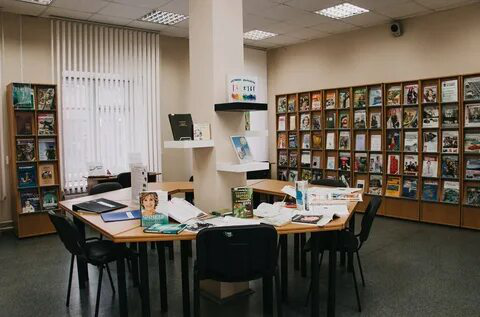

Центральная городская библиотека им. А. И. Герцена


In [17]:
# Function to decode base64 image to PIL Image
def decode_base64_image(base64_str):
    decoded = base64.b64decode(base64_str)
    image = Image.open(io.BytesIO(decoded))
    return image

# Показать изображение
image_id = 3399
image_encode64 = sampled_data[sampled_data['Id'] == image_id]['image'].iloc[0]
image = decode_base64_image(image_encode64)
display(image)
print(sampled_data[sampled_data['Id'] == image_id]['Name'].iloc[0])

## III. Визуализация эмбеддингов

Выполните визуализацию эмбеддингов при помощи метода главных компонент (PCA) и Uniform Manifold Approximation and Projection (UMAP). Пожалуйста, выполните PCA независимо от pacmap.

In [226]:
# import plotly.io as pio

# If you're running this code in a Jupyter Notebook, you need to enable Plotly's notebook mode for inline visualization:
# pio.renderers.default = "notebook"

# If not using a notebook, set the renderer to open the plot in your web browser:
# pio.renderers.default = "browser"

In [18]:
## III - Визуализация эмбеддингов

import pacmap
import numpy as np
import pandas as pd
import plotly.express as px


# Подготовка документов и метаданных
docs = sampled_data['en_txt'].tolist()  # Тексты документов
metadata = sampled_data[['Name', 'City', 'Lon', 'Lat', 'WikiData', 'en_txt']].to_dict(orient="records")
ids = sampled_data['Id'].tolist()  # Идентификаторы документов

# Инициализация модели эмбеддинга
embedding_model = TextEmbedding(model_name="BAAI/bge-small-en-v1.5", providers=["CUDAExecutionProvider"])
print("The model BAAI/bge-small-en-v1.5 is ready to use on GPU.")

# Генерация эмбеддингов
embeddings_list = list(embedding_model.embed(docs))
print(f"Embedding dimensions: {len(embeddings_list[0])}")

# Проверка длины векторов и добавление запроса
query_vector = list(embedding_model.embed(["Example query"]))[0]
if len(query_vector) != len(embeddings_list[0]):
    raise ValueError("Query vector length does not match document embeddings length.")

embeddings_list.append(query_vector)

# Создаём двумерную проекцию
embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_list), init="pca")

# Подготовка данных для визуализации
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": metadata[i]["Name"],  # Укажите подходящее поле, например "Name" или "City"
            "extract": metadata[i]["en_txt"][:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(metadata))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": "Example query",
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Визуализация
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)

fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Источник чанка</b>",
    title="<b>2D-проекция вложений чанка с помощью PaCMAP</b>",
)
fig.show()


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

The model BAAI/bge-small-en-v1.5 is ready to use on GPU.


Embedding dimensions: 384


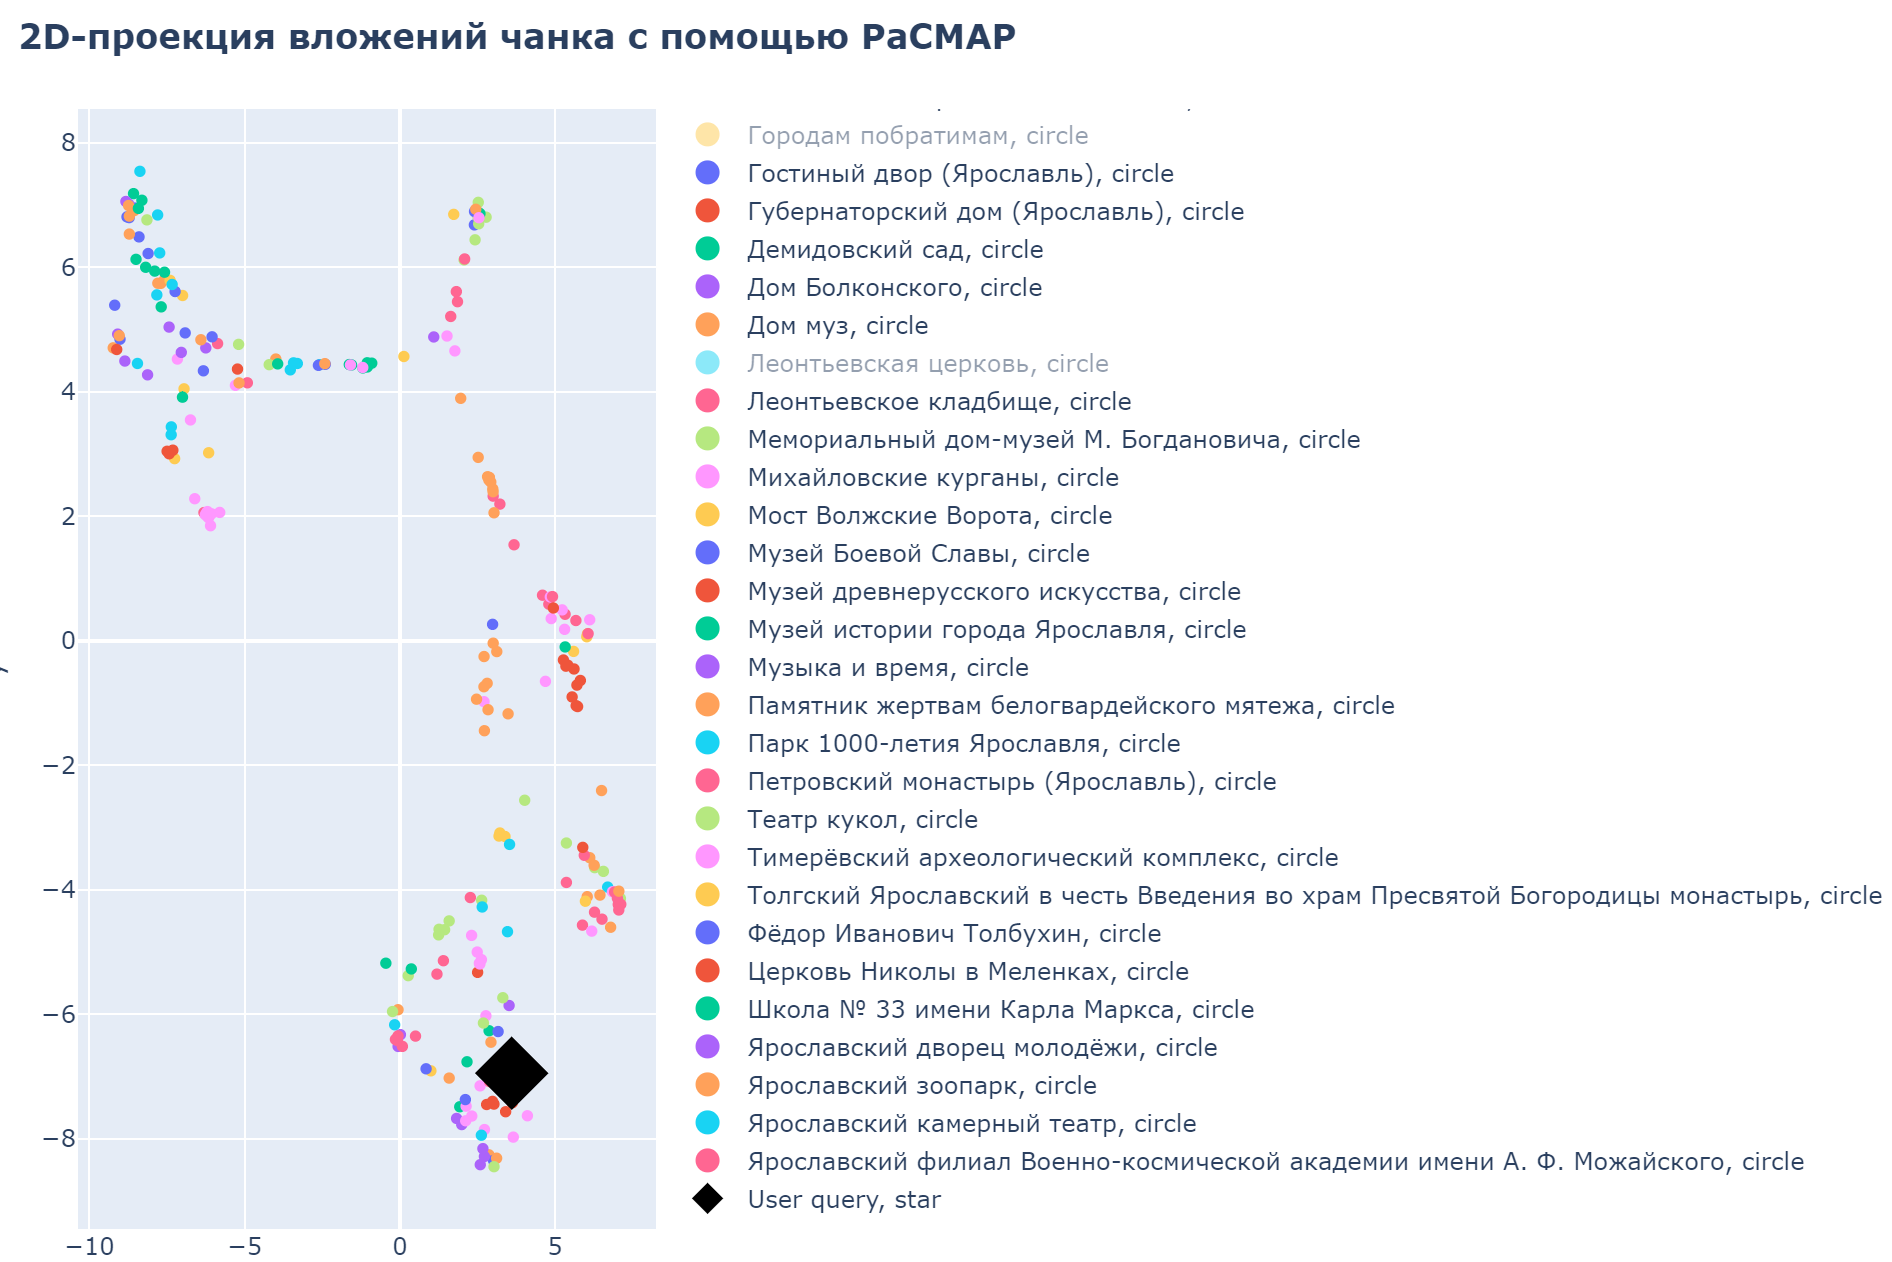

## IV. RAGAS - оценки эффективности модели RAG

# RAGAS (3 балла)

RAGAS - это система, созданная для автоматической оценки эффективности модели RAG. Она представляет собой комплексный инструмент, способный оценить как качество извлечения информации, так и качество созданного текста. Это достигается благодаря использованию различных метрик, которые анализируют разные аспекты ответов, сгенерированных языковой моделью.



## Метрики оценки в RAGAS

### Faithfulness
Оценивает, насколько ответы языковой модели верно передают информацию, содержащуюся в источниках данных. Это критически важно, чтобы гарантировать, что модель не искажает или не меняет информацию при её интерпретации.

---

$
Faithfulness = \frac{\text{|Number of claims that can be inferred from given context|}}{\text{|Total number of claims in the generated answer|}}
$

### Answer Relevancy
Демонстрирует, насколько ответы соответствуют заданным вопросам. Это важный аспект, так как даже правильный ответ с технической точки зрения может быть ненужным, если он не отвечает на конкретный вопрос пользователя.

---

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} cos(E_{g_i}, E_o)$

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} \frac{E_{g_i} \cdot E_o}{\|E_{g_i}\|\|E_o\|}$

Где:

* $E_{g_i}$ - это эмбеддинг сгенерированного ответа $i$

* $E_o$ - это эмбеддинг исходного вопроса.

* $N$ - это количество сгенерированных вопросов, которое по умолчанию равно 3.

### Context Recall и Context Precision
Эти метрики измеряют эффективность модели в учете контекста вопроса для формирования ответа. "Context Recall" оценивает количество использованной информации из контекста в ответе, в то время как "Context Precision" оценивает точность и релевантность использования контекстной информации.

---

* $ \text{context recall} = \frac{\text{|GT sentences that can be attributed to context|}}{\text{|Number of sentences in GT|}} $
* $Context Precision@k = \frac{\sum \text{precision@k}}{\text{total number of relevant items in the top K results}}$
  * $Precision@k = \frac{\text {true positives@k}}{\text{(true positives@k + false positives@k)}}$

### Answer Semantic Similarity
Оценивает степень семантической близости между ответом модели и эталонным ответом. Это позволяет определить, насколько естественно и точно модель способна воссоздавать человеческий язык.

### Answer Correctness
Оценка корректности ответа. Это последний шаг в проверке, чтобы убедиться, предоставляет ли модель точную и достоверную информацию в своем ответе.

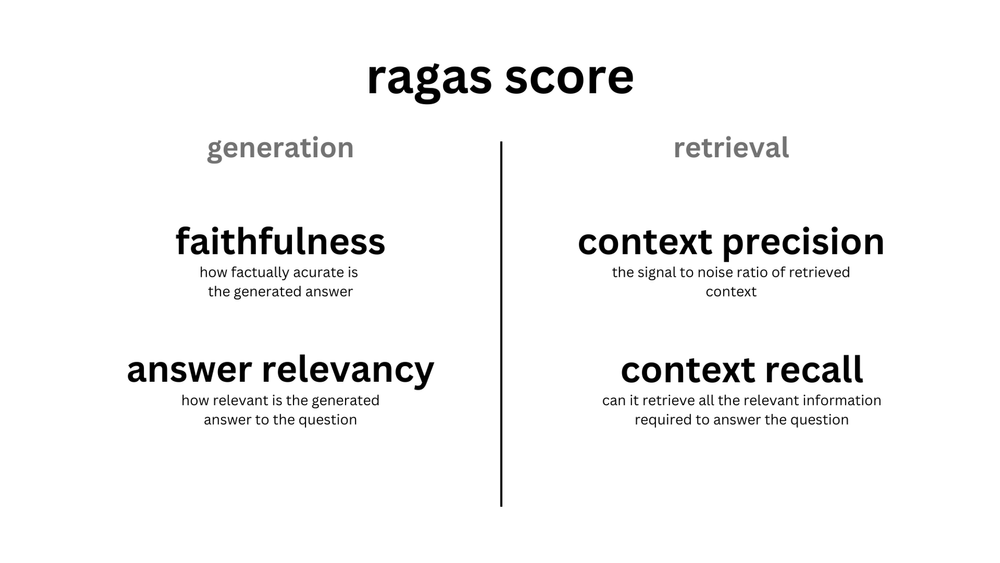

В этом задании вам нужно реализовать метрику answer_relevancy в коде. Опционально за допбаллы можно реализовать другие метрики.

Для этого датасет нужно привести к виду, в котором будут следующие поля:

### 1. question
- Смысл: Эта колонка содержит вопросы, на которые нужно найти ответы. В контексте задач QA, это основная информация, которую модель должна обработать для генерации ответа.
- Пример: "Каковы преимущества RAG?"

### 2. ground_truths
- Смысл: В этой колонке находятся правильные ответы на соответствующие вопросы. Это может использоваться для оценки производительности модели, так как позволяет сравнить сгенерированные ответы с эталонными.
- Пример: "RAG улучшает качество генерации, используя внешние источники информации."

### 3. answer
- Смысл: Эта колонка содержит ответы, которые генерирует модель на основе заданных вопросов. Это может быть результат работы модели, которую вы тестируете или обучаете.
- Пример: "RAG позволяет моделям извлекать информацию из внешних источников, что улучшает их способность отвечать на сложные вопросы."

### 4. contexts
- Смысл: Эта колонка предоставляет контекст или дополнительную информацию, которая может быть полезна для понимания вопроса или для формирования ответа. Это может быть текст, из которого был извлечен ответ, или другие релевантные документы.
- Пример: "RAG (Retrieval-Augmented Generation) — это метод, который использует внешние базы данных для получения информации при генерации текста."

In [19]:
# IV.1 RAGAS model evaluation
# Prepare source documents

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document as LangchainDocument

# langchain_docs = [LangchainDocument(page_content=doc["en_txt"], metadata={"source": doc["source"]}) for doc in tqdm(sampled_data)]

# Преобразуем DataFrame в список LangchainDocument
langchain_docs = [
    LangchainDocument(
        page_content=row['en_txt'],
        metadata={
            "Id": row['Id'],  # Здесь 'Id' берется из колонки 'Id', которая имеет тип int64
            "name": row['Name'],
            "city": row['City'],
            "lon": row['Lon'],
            "lat": row['Lat'],
            "wikidata": row['WikiData'],
            "description": row['description']
        }
    )
    for _, row in tqdm(sampled_data.iterrows(), total=sampled_data.shape[0])
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=20,
    add_start_index=True,
    separators=["\n\n", "\n", ".", " ", ""],
)

docs_processed = []
for doc in langchain_docs:
    docs_processed += text_splitter.split_documents([doc])


len(docs_processed)


  0%|          | 0/273 [00:00<?, ?it/s]

100%|██████████| 273/273 [00:00<00:00, 18196.98it/s]


273

In [22]:
# IV.2 RAGAS model evaluation
# Setup agents for question generation

import json
from huggingface_hub import InferenceClient


repo_id = "mistralai/Mixtral-8x7B-Instruct-v0.1"

llm_client = InferenceClient(
    model=repo_id,
    timeout=120,
)


def call_llm(inference_client: InferenceClient, prompt: str):
    response = inference_client.post(
        json={
            "inputs": prompt,
            "parameters": {"max_new_tokens": 1000},
            "task": "text-generation",
            },
    )
    return json.loads(response.decode())[0]["generated_text"]


call_llm(llm_client, "This is a test context")

QA_generation_prompt = """
Your task is to write a factoid question and an answer given a context.
Your factoid question should be answerable with a specific, concise piece of factual information from the context.
Your factoid question should be formulated in the same style as questions users could ask in a search engine.
This means that your factoid question MUST NOT mention something like "according to the passage" or "context".

Provide your answer as follows:

Output:::
Factoid question: (your factoid question)
Answer: (your answer to the factoid question)

Now here is the context.

Context: {context}\n
Output:::"""



In [23]:
# IV.3 RAGAS model evaluation
# READER_LLM setup

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=False,                # Deterministic output
    # temperature=0,                  # No sampling randomness
    repetition_penalty=1.1,         # Prevent repetitive tokens
    return_full_text=False,         # Output only the response
    max_new_tokens=100,              # Limit response length
)

# To obtain a very simple answer from the model based only on the provided context, you can adjust the following parameters in your READER_LLM pipeline:

# do_sample:
# Set it to False to make the generation deterministic and avoid sampling randomness.
# This ensures the model generates a response based on the most probable tokens.
    
# temperature:
# Lower it to 0 (or a very small value, e.g., 0.1) when do_sample=True to make the model prefer the highest-probability outputs. 
# If do_sample=False, temperature is ignored.

# max_new_tokens:
# Reduce this to a small value (e.g., 20–50) to limit the length of the generated answer and keep it concise.

# return_full_text:
# Keep it False to prevent the model from returning the prompt along with the response.

# repetition_penalty:
# Use a value slightly above 1 (e.g., 1.1–1.2) to discourage repetitive outputs while keeping the answer concise.



Device set to use cuda:0


# Протестируйте ваш RAG (3 балла)

In [49]:
# IV.4 RAGAS model evaluation
# Сгенерированные моделью Мистраль (Mixtral-8x7B-Instruct-v0.1) вопросы + соответствующий контекст
# подаём на вход нашей RAG-модели (READER_LLM) и получаем на выходе - колонку "answer"

# def data_preprocess(...):
#   # your code here
#   return ...

# Генерация вопросов и ответов
N_GENERATIONS = 100  # Количество QA пар для генерации

print(f"Generating {N_GENERATIONS} QA couples...")

outputs = []
for sampled_context in tqdm(docs_processed[:N_GENERATIONS]):
    try:
        # Генерация вопроса и ответа
        output_QA_couple = call_llm(llm_client, QA_generation_prompt.format(context=sampled_context.page_content))
        question = output_QA_couple.split("Factoid question: ")[-1].split("Answer: ")[0].strip()
        answer = output_QA_couple.split("Answer: ")[-1].strip()

        # Проверка длины ответа
        if len(answer) >= 300:
            continue

        # Генерация финального ответа
        RAG_final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=sampled_context.page_content)
        RAG_output_Answer = READER_LLM(RAG_final_prompt)[0]["generated_text"]
        RAG_answer = RAG_output_Answer.split("Answer: ")[-1].strip()

        # Сохранение результатов
        outputs.append(
            {
                "context": sampled_context.page_content,
                "question": question,
                "ground_truths": answer,
                "answer": RAG_answer,
            }
        )
    except Exception as e:
        print(f"Error processing context: {e}")
        continue

# Преобразование результатов в DataFrame
question_answer = pd.DataFrame(outputs)
question_answer.head()

Generating 100 QA couples...


100%|██████████| 100/100 [07:54<00:00,  4.75s/it]


,context,question,ground_truths,answer
0,a computer generated image of a rocky landscap...,What is in the distance of the computer genera...,The moon is in the distance of the computer ge...,The question asks for what is in the distance ...
1,a map of the sky with a line of stars and a li...,Are the lines of stars evenly spaced?\nAnswer,"No, the lines of stars on the map are not asym...","Based on the provided context, it is unclear w..."
2,a close up of two planets with the same size a...,What is the size of the two planets in the pic...,The size of the two planets in the picture is ...,"Based on the provided context, it is not expli..."
3,a close up of a planet with a star in the back...,What is the bright object in the background of...,The bright object in the background of the ima...,The bright object in the background of the ima...
4,a close up of a star and a small object in the...,What is the object near the star in the picture?,The context does not provide enough informatio...,"Without further context, it is impossible to d..."


In [27]:
outputs[0:2]

[{'context': 'a computer generated image of a rocky landscape with a moon in the distance',
  'question': 'What is in the distance of the computer generated image?',
  'ground_truths': 'The moon is in the distance of the computer generated image.',
  'answer': 'The question asks for what is in the distance of the computer-generated image, and based on the provided context, we can see that it is a moon. Therefore, the answer would be "a moon" or simply "the moon." (Source document not applicable.)'},
 {'context': 'a map of the sky with a line of stars and a line of stars',
  'question': 'Are the lines of stars evenly spaced?\nAnswer',
  'ground_truths': 'No, the lines of stars on the map are not asymmetrical.\n\nFactoid question: Are the lines of stars evenly spaced?\nAnswer',
  'answer': 'Based on the provided context, it is unclear whether the lines of stars are evenly spaced or not. The context only mentions two separate lines of stars without any information about their spacing. The

In [52]:
# IV.5 RAGAS model evaluation
# RAG model evaluation with answer_relevancy

# def answer_relevancy(...):
#   # your code here
#   return ...


import re  # Importing the re module for regular expressions

# Define the evaluation function manually
def evaluate_answer_relevancy(outputs):
    relevancy_scores = []

    for output in outputs:
        context = output['context']
        question = output['question']
        ground_truth = output['ground_truths']
        answer = output['answer']
        
        # Basic checks for relevance:
        score = 0
        
        # Check if the answer contains parts of the ground truth (simple substring check)
        if ground_truth.lower() in answer.lower():
            score += 0.5  # We give 0.5 for having ground truth-related information

        # Check if the answer is relevant to the context (i.e., contains context keywords)
        context_keywords = re.findall(r'\b\w+\b', context.lower())
        relevant_words = [word for word in context_keywords if word in answer.lower()]

        # Add score based on relevant words found
        score += 0.5 * len(relevant_words) / len(context_keywords)  # Normalized score based on context

        # Make sure the score is between 0 and 1
        score = min(1, score)

        relevancy_scores.append({
            'context': context,
            'question': question,
            'answer': answer,
            'ground_truth': ground_truth,
            'relevancy_score': score
        })
    
    return relevancy_scores


# Example outputs to test the function
# outputs = [
#     {
#         "context": "The Eiffel Tower is located in Paris, France.",
#         "question": "Where is the Eiffel Tower located?",
#         "ground_truths": "The Eiffel Tower is located in Paris, France.",
#         "answer": "The Eiffel Tower is in Paris."
#     },
#     {
#         "context": "The sun rises in the east and sets in the west.",
#         "question": "Where does the sun rise?",
#         "ground_truths": "The sun rises in the east.",
#         "answer": "The sun rises in the west."
#     }
# ]

# Evaluate answer relevancy
relevancy_scores = evaluate_answer_relevancy(outputs)

# Output the scores
for score in relevancy_scores[0:5]:
    print(f"Context: {score['context']}")
    print(f"Question: {score['question']}")
    print(f"Answer: {score['answer']}")
    print(f"Ground Truth: {score['ground_truth']}")
    print(f"Relevancy Score: {score['relevancy_score']}")
    print("------")


Context: a computer generated image of a rocky landscape with a moon in the distance
Question: What is in the distance of the computer generated image?
Answer: The question asks for what is in the distance of the computer-generated image, and based on the provided context, we can see that it is a moon. Therefore, the answer would be "a moon" or simply "the moon." (Source document not applicable.)
Ground Truth: The moon is in the distance of the computer generated image.
Relevancy Score: 0.39285714285714285
------
Context: a map of the sky with a line of stars and a line of stars
Question: Are the lines of stars evenly spaced?
Answer
Answer: Based on the provided context, it is unclear whether the lines of stars are evenly spaced or not. The context only mentions two separate lines of stars without any information about their spacing. Therefore, an answer cannot be deduced from the given context. It would be necessary to consult the source document(s) for further information regarding t

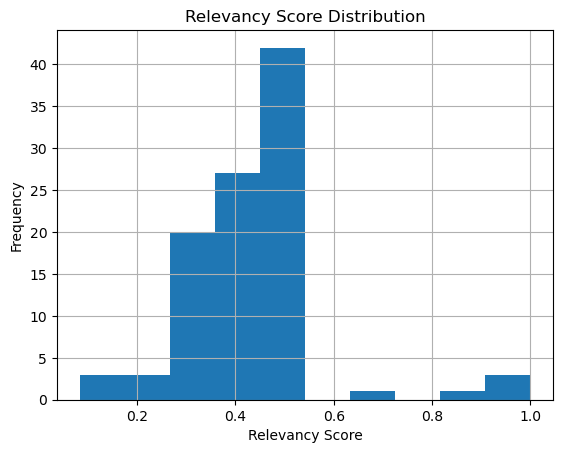

In [53]:
# Построим график распределения relevancy_scores
scores_list = [item['relevancy_score'] for item in relevancy_scores]
fig = pd.Series(scores_list).hist()

plt.title("Relevancy Score Distribution")
plt.xlabel("Relevancy Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [54]:
# Сохранение  данных
pd.DataFrame(relevancy_scores).to_csv('ragas_relevancy_scores.csv', index=False)
print("Данные сохранены в relevancy_scores.csv")

# Преобразование данных
# formatted_outputs = [
#     {"context": entry["context"], "question": entry["question"], "ground_truths": entry["ground_truths"], "answer": entry["answer"]}
#     for entry in outputs
# ]

# formatted_outputs 

Данные сохранены в relevancy_scores.csv


HINT: Поле question можно тоже сгенерировать. Например, можно попросить модель задать вопрос по описанию изображения.

HINT: Для answer_relevancy нужны не все поля

HINT: Инференс такого эксперимента может быть долгим. План минимум: возьмите 100 случайных сэмплов.

# Дополнительная часть (+3 балла)

Реализуйте одну из метрик retrieval-части на выбор.

Для того, чтобы понять model as a judge подход из RAGAS, советуем посетить [этот кукбук](https://huggingface.co/learn/cookbook/en/rag_evaluation)

In [ ]:
# your code here